# Section 2 : Hyperparameters
This section aims to perform a hyperparameter search to improve the performance of a custom model that distinguishes between any three classes.


## Task 1: Hyperparameter Optimization 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from autogluon.tabular import TabularPredictor

/Users/aryan/Desktop/Academics /Semester 4/AI Software tools and techniques/-CS-203-MLP-Model-Implementation-Experiment-Tracking-Hyperparameters/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)  # Reshape for one-hot encoding

# One-hot encoding
ohe = OneHotEncoder(sparse_output=False)
y_onehot = ohe.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [3]:
# Define MLP model class
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Training function with hyperparameter tuning
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, torch.max(y_batch, 1)[1])
            loss.backward()
            optimizer.step()
    
    # Evaluate
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            y_pred.extend(torch.argmax(outputs, axis=1).numpy())
            y_true.extend(torch.argmax(y_batch, axis=1).numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, f1, y_true, y_pred

Batch Size: 2, LR: 0.001, Epochs: 1 -> Accuracy: 0.6000, F1: 0.4889


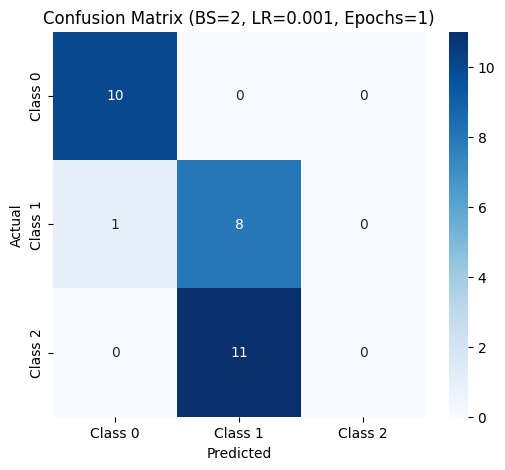

Sample Predictions:
Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 1, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 1, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 1, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 1, Truth: 1
Batch Size: 2, LR: 0.001, Epochs: 3 -> Accuracy: 0.8667, F1: 0.8579


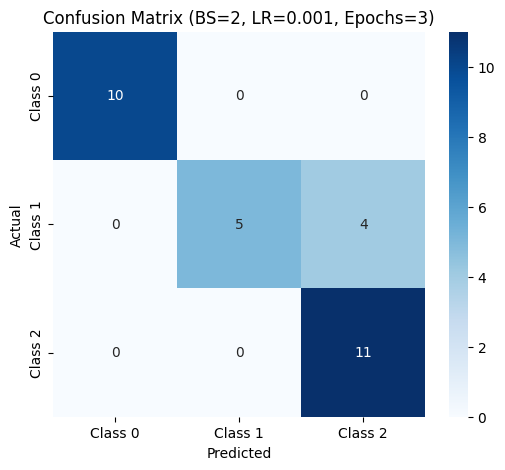

Sample Predictions:
Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 1, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 2, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 1, Truth: 1
Batch Size: 2, LR: 0.001, Epochs: 5 -> Accuracy: 0.8333, F1: 0.8167


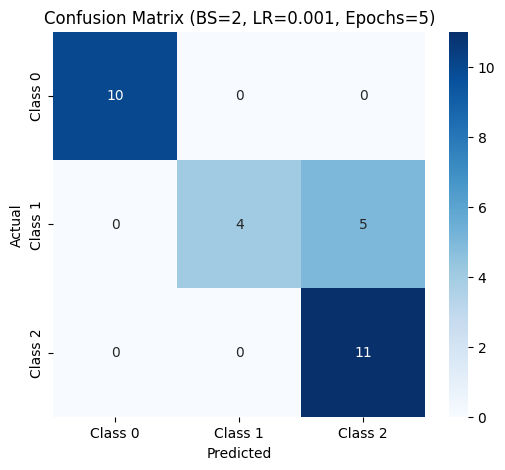

Sample Predictions:
Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 2, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 2, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 2, Truth: 1
Batch Size: 2, LR: 1e-05, Epochs: 1 -> Accuracy: 0.5333, F1: 0.4510


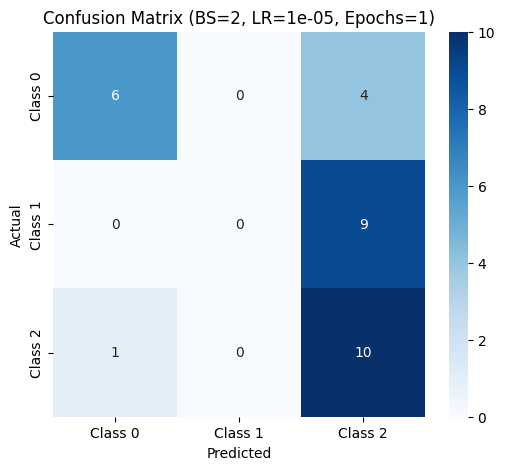

Sample Predictions:
Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 2, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 2, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 2, Truth: 1
Batch Size: 2, LR: 1e-05, Epochs: 3 -> Accuracy: 0.3333, F1: 0.2370


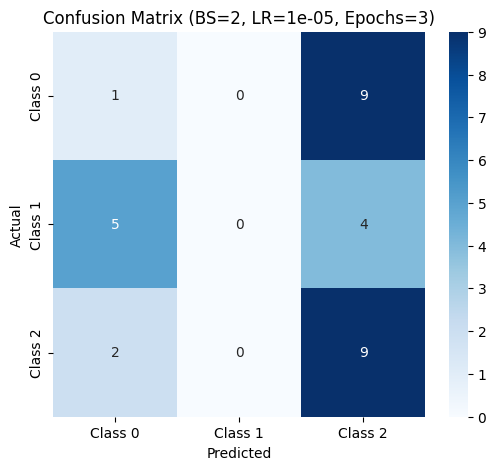

Sample Predictions:
Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 0, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 0, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 0, Truth: 1
Batch Size: 2, LR: 1e-05, Epochs: 5 -> Accuracy: 0.5333, F1: 0.4433


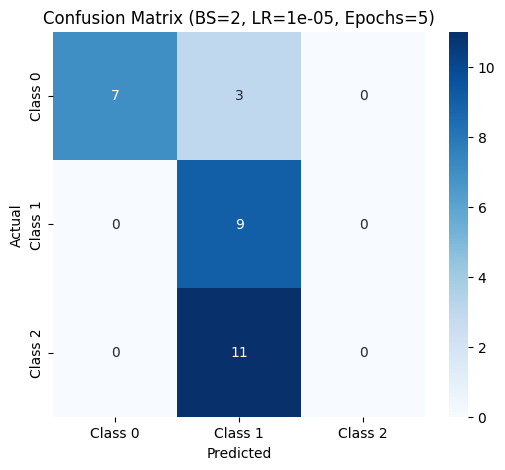

Sample Predictions:
Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 1, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 1, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 1, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 1, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 1, Truth: 1
Batch Size: 4, LR: 0.001, Epochs: 1 -> Accuracy: 0.3000, F1: 0.1459


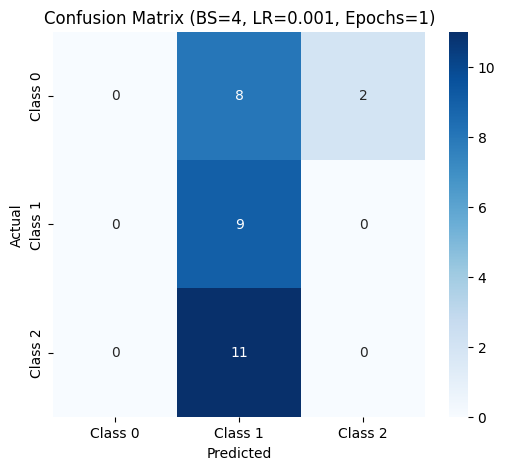

Sample Predictions:
Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 1, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 1, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 1, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 1, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 1, Truth: 1
Batch Size: 4, LR: 0.001, Epochs: 3 -> Accuracy: 0.8333, F1: 0.8167


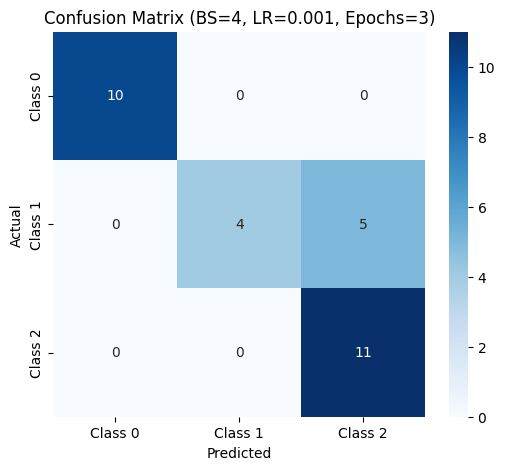

Sample Predictions:
Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 2, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 2, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 2, Truth: 1
Batch Size: 4, LR: 0.001, Epochs: 5 -> Accuracy: 0.8333, F1: 0.8167


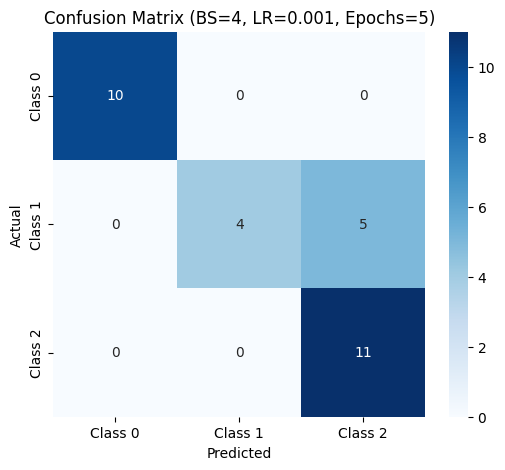

Sample Predictions:
Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 2, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 2, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 2, Truth: 1
Batch Size: 4, LR: 1e-05, Epochs: 1 -> Accuracy: 0.3667, F1: 0.3000


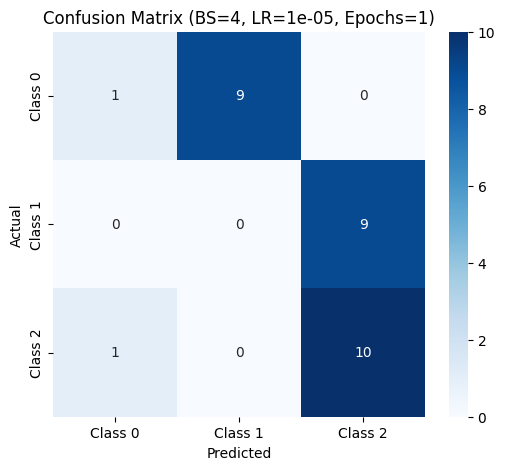

Sample Predictions:
Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 2, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 2, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 2, Truth: 1
Batch Size: 4, LR: 1e-05, Epochs: 3 -> Accuracy: 0.4333, F1: 0.3767


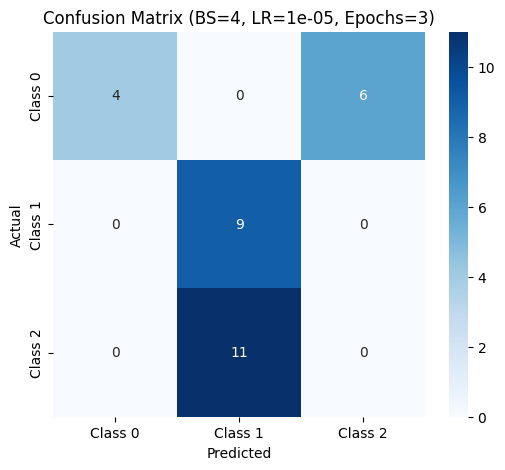

Sample Predictions:
Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 1, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 1, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 1, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 1, Truth: 1
Batch Size: 4, LR: 1e-05, Epochs: 5 -> Accuracy: 0.6667, F1: 0.5509


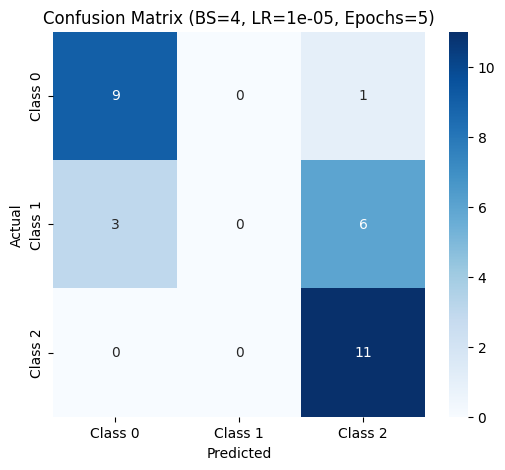

Sample Predictions:
Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 2, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 2, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 2, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 2, Truth: 1


In [4]:
# Hyperparameter search
batch_sizes = [2, 4]
learning_rates = [1e-3, 1e-5]
epochs_list = [1, 3, 5]

results = []

for batch_size in batch_sizes:
    for lr in learning_rates:
        for epochs in epochs_list:
            # Prepare DataLoader
            train_dataset = TensorDataset(X_train, y_train)
            test_dataset = TensorDataset(X_test, y_test)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            
            # Initialize model, loss, optimizer
            model = MLPModel(input_size=4, hidden_units=16, output_size=3)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # Train and evaluate
            accuracy, f1, y_true, y_pred = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs)
            
            # Store results
            results.append((batch_size, lr, epochs, accuracy, f1))
            print(f'Batch Size: {batch_size}, LR: {lr}, Epochs: {epochs} -> Accuracy: {accuracy:.4f}, F1: {f1:.4f}')
            
            # Confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title(f"Confusion Matrix (BS={batch_size}, LR={lr}, Epochs={epochs})")
            plt.show()
            
            # Show 5 test samples
            print("Sample Predictions:")
            for i in range(5):
                print(f"Input: {X_test[i].numpy()}, Prediction: {y_pred[i]}, Truth: {y_true[i]}")




In [ ]:
# Display all results
## make this into dataframe
print("\nHyperparameter Search Results:")
for res in results:
    print(f"Batch Size: {res[0]}, LR: {res[1]}, Epochs: {res[2]} -> Accuracy: {res[3]:.4f}, F1: {res[4]:.4f}")

# Identify the best hyperparameters
best_params = max(results, key=lambda x: x[3])  # Sorting by accuracy
print(f"\nBest Hyperparameters: Batch Size={best_params[0]}, Learning Rate={best_params[1]}, Epochs={best_params[2]} -> Accuracy={best_params[3]:.4f}, F1={best_params[4]:.4f}")


Hyperparameter Search Results:
Batch Size: 2, LR: 0.001, Epochs: 1 -> Accuracy: 0.6000, F1: 0.4889
Batch Size: 2, LR: 0.001, Epochs: 3 -> Accuracy: 0.8667, F1: 0.8579
Batch Size: 2, LR: 0.001, Epochs: 5 -> Accuracy: 0.8333, F1: 0.8167
Batch Size: 2, LR: 1e-05, Epochs: 1 -> Accuracy: 0.5333, F1: 0.4510
Batch Size: 2, LR: 1e-05, Epochs: 3 -> Accuracy: 0.3333, F1: 0.2370
Batch Size: 2, LR: 1e-05, Epochs: 5 -> Accuracy: 0.5333, F1: 0.4433
Batch Size: 4, LR: 0.001, Epochs: 1 -> Accuracy: 0.3000, F1: 0.1459
Batch Size: 4, LR: 0.001, Epochs: 3 -> Accuracy: 0.8333, F1: 0.8167
Batch Size: 4, LR: 0.001, Epochs: 5 -> Accuracy: 0.8333, F1: 0.8167
Batch Size: 4, LR: 1e-05, Epochs: 1 -> Accuracy: 0.3667, F1: 0.3000
Batch Size: 4, LR: 1e-05, Epochs: 3 -> Accuracy: 0.4333, F1: 0.3767
Batch Size: 4, LR: 1e-05, Epochs: 5 -> Accuracy: 0.6667, F1: 0.5509

Best Hyperparameters: Batch Size=2, Learning Rate=0.001, Epochs=3 -> Accuracy=0.8667, F1=0.8579


In [ ]:
# !pip install autogluon
# we downloaded this via pip in the terminal 

## Task 2 : Automated Hyperparameter Search

In [2]:
from autogluon.tabular import TabularPredictor
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor
import pandas as pd
import numpy as np

In [16]:
# Load or generate data
def get_data():
    X, y = make_classification(n_samples=1000, n_features=10, random_state=42)
    return pd.DataFrame(X, columns=[f'feature_{i}' for i in range(10)]), pd.Series(y, name='target')

X, y = get_data()
df = X.copy()
df['target'] = y
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Define hyperparameter grids
param_grid = {
    'LR': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},  # Logistic Regression
    'RF': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},  # Random Forest
    'XGB': {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [50, 100]}  # XGBoost
}

# Grid Search
grid_results = {}
for model, params in param_grid.items():
    predictor = TabularPredictor(label='target', path=f'models/{model}_grid').fit(
        train_data, hyperparameters={model: params}  # ✅ Corrected this line
    )
    perf = predictor.evaluate(test_data)
    grid_results[model] = perf

# Random Search
random_results = {}
for model, params in param_grid.items():
    predictor = TabularPredictor(label='target', path=f'models/{model}_random').fit(
        train_data, hyperparameters={model: params},  # ✅ Corrected this line
        hyperparameter_tune_kwargs={'searcher': 'random'}
    )
    perf = predictor.evaluate(test_data)
    random_results[model] = perf

# Bayesian Optimization
bayes_results = {}
for model, params in param_grid.items():
    predictor = TabularPredictor(label='target', path=f'models/{model}_bayes').fit(
        train_data, hyperparameters={model: params},  # ✅ Corrected this line
        hyperparameter_tune_kwargs={'searcher': 'bayesopt'}
    )
    perf = predictor.evaluate(test_data)
    bayes_results[model] = perf

# Create results table
def format_results(results):
    return pd.DataFrame.from_dict(results, orient='index')

grid_df = format_results(grid_results)
random_df = format_results(random_results)
bayes_df = format_results(bayes_results)

# Display comparison
display(grid_df, random_df, bayes_df)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          20
Memory Avail:       7.67 GB / 31.65 GB (24.2%)
Disk Space Avail:   50.03 GB / 430.79 GB (11.6%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference speed.
	presets='good'         : Good accur

RuntimeError: No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.

In [ ]:
# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=10, random_state=42)
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(10)])
df['target'] = y

# Split into train and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Define AutoGluon-supported models & hyperparameter grids
param_grid = {
    'GBM': {'num_boost_round': 100, 'learning_rate': 0.1},  # Gradient Boosting Machine (LightGBM)
    'RF': {'n_estimators': 100, 'max_depth': 10},           # Random Forest
    'XT': {'n_estimators': 100, 'max_depth': 10}            # Extra Trees
}

# Grid Search
grid_results = {}
for model, params in param_grid.items():
    predictor = TabularPredictor(label='target', path=f'models/{model}_grid').fit(
        train_data, hyperparameters={model: params}  # ✅ Corrected Model Names
    )
    perf = predictor.evaluate(test_data)
    grid_results[model] = perf

# Display results
grid_df = pd.DataFrame.from_dict(grid_results, orient='index')
display(grid_df)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          20
Memory Avail:       7.40 GB / 31.65 GB (23.4%)
Disk Space Avail:   50.03 GB / 430.79 GB (11.6%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference speed.
	presets='good'         : Good accur

,accuracy,balanced_accuracy,mcc,roc_auc,f1,precision,recall
GBM,0.890,0.898674,0.794458,0.944681,0.892157,0.978495,0.819820
RF,0.875,0.877366,0.750753,0.948983,0.883721,0.913462,0.855856
XT,0.855,0.858235,0.712264,0.937443,0.863850,0.901961,0.828829


In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.datasets import load_iris
from autogluon.tabular import TabularPredictor

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)  # Reshape for one-hot encoding

# One-hot encoding
ohe = OneHotEncoder(sparse_output=False)
y_onehot = ohe.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [24]:
# Convert to DataFrame for AutoGluon
df_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(4)])
df_train['target'] = np.argmax(y_train, axis=1)  # Convert one-hot to class labels

df_test = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(4)])
df_test['target'] = np.argmax(y_test, axis=1)

# Define hyperparameter search space
hyperparameters = {
    'NN_TORCH': {  # Neural Network with PyTorch
        'num_epochs': 5,
        'learning_rate': 1e-3,
        'batch_size': 4,
        'activation': 'relu',
        'hidden_size': 16,
    }
}

# Define search methods
search_methods = {
    "grid": {"searcher": "grid"},
    "random": {"searcher": "random"},
    "hyperband": {"searcher": "bayesopt", "scheduler": "hyperband"},
    "bayesopt": {"searcher": "bayesopt"},
}

# Store results
results = {}

# Perform Hyperparameter Tuning using Grid Search, Random Search, Hyperband, and Bayesian Optimization
for method, tuning_kwargs in search_methods.items():
    print(f"\n🔍 Running {method} search...")
    predictor = TabularPredictor(label="target", path=f"models/{method}").fit(
        df_train,
        hyperparameters=hyperparameters,
        hyperparameter_tune_kwargs=tuning_kwargs,  # AutoGluon tuning parameter
    )
    perf = predictor.evaluate(df_test)
    results[method] = perf

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient="index")
print("\n Hyperparameter Tuning Results:\n", results_df)

# Get predictions from the best model (e.g., Grid Search)
best_model = "grid"  # Change this to the best-performing method
predictor_best = TabularPredictor.load(f"models/{best_model}")
y_pred = predictor_best.predict(df_test.drop(columns=["target"]))

# Compute Confusion Matrix
conf_matrix = confusion_matrix(df_test["target"], y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Show 5 sample predictions
df_test_sample = df_test.iloc[:5].copy()
df_test_sample["Predicted"] = predictor_best.predict(df_test_sample.drop(columns=["target"]))

print("\n Sample Predictions:\n", df_test_sample)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          20
Memory Avail:       7.03 GB / 31.65 GB (22.2%)
Disk Space Avail:   49.54 GB / 430.79 GB (11.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference speed.
	presets='good'         : Good accur


🔍 Running grid search...


2025-02-25 02:56:15,069	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
Traceback (most recent call last):
  File "C:\Users\Parth\AppData\Roaming\Python\Python310\site-packages\autogluon\core\trainer\abstract_trainer.py", line 2497, in _train_single_full
    hpo_models, hpo_results = model.hyperparameter_tune(
  File "C:\Users\Parth\AppData\Roaming\Python\Python310\site-packages\autogluon\core\models\abstract\abstract_model.py", line 1744, in hyperparameter_tune
    hpo_executor.initialize(hyperparameter_tune_kwargs, default_num_trials=default_num_trials, time_limit=time_limit)
  File "C:\Users\Parth\AppData\Roaming\Python\Python310\site-packages\autogluon\core\hpo\executors.py", line 349, in initialize
    hyperparameter_tune_kwargs["scheduler"], hyperparameter_tune_kwargs["scheduler"]
KeyError: 'scheduler'
'scheduler'
No base models to train on, skipping auxiliary stack level 2...
AutoGl

RuntimeError: No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.

In [26]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, f1_score
import torch

# 1. Data Preparation
# Load dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)  # Reshape for one-hot encoding

# One-hot encoding
ohe = OneHotEncoder(sparse_output=False)
y_onehot = ohe.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42
)

# Convert to Pandas DataFrames for AutoGluon
X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
X_test = pd.DataFrame(X_test, columns=[f"feature_{i}" for i in range(X_test.shape[1])])
y_train = pd.DataFrame(y_train, columns=[f"target_{i}" for i in range(y_train.shape[1])])
y_test = pd.DataFrame(y_test, columns=[f"target_{i}" for i in range(y_test.shape[1])])

# Concatenate features and target for AutoGluon
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# AutoGluon expects a single target column for classification
# We need to determine the predicted class from the one-hot encoded targets

def convert_onehot_to_class(df, target_columns):
    """Converts one-hot encoded target columns to a single class label."""
    class_labels = df[target_columns].idxmax(axis=1).str.replace('target_', '').astype(int)
    return class_labels

target_columns = [col for col in train_data.columns if col.startswith('target_')]
train_data['target'] = convert_onehot_to_class(train_data, target_columns)
test_data['target'] = convert_onehot_to_class(test_data, target_columns)

# Drop the one-hot encoded target columns
train_data = train_data.drop(columns=target_columns)
test_data = test_data.drop(columns=target_columns)

train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)

# 2. Define the search space (Simplified initially)
search_space = {
    "NN_TORCH": {
        "num_epochs": [1, 3],
        "learning_rate": [1e-3, 1e-5],
        "batch_size": [2, 4],
    }
}

def evaluate_model(predictor, test_data):
    """Evaluates the trained model and returns accuracy and F1 score."""
    try:
        y_true = test_data["target"].to_numpy()
        X_test = test_data.drop(columns=["target"])
        y_pred = predictor.predict(X_test).to_numpy()
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="weighted")
        return accuracy, f1
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return np.nan, np.nan  # Return NaN values if evaluation fails


# 3. Implement Grid Search
def grid_search(train_data, test_data, search_space):
    """Performs grid search using AutoGluon."""
    results = []
    # Iterate over all combinations of hyperparameters
    for num_epochs in search_space["NN_TORCH"]["num_epochs"]:
        for learning_rate in search_space["NN_TORCH"]["learning_rate"]:
            for batch_size in search_space["NN_TORCH"]["batch_size"]:
                hyperparameters = {
                    "NN_TORCH": {
                        "num_epochs": num_epochs,
                        "learning_rate": learning_rate,
                        "batch_size": batch_size,
                    }
                }

                try:
                    predictor = TabularPredictor(
                        label="target", eval_metric="accuracy"
                    )
                    predictor.fit(
                        train_data,
                        hyperparameters=hyperparameters,
                        time_limit=60,
                        verbosity=0,
                    )

                    accuracy, f1 = evaluate_model(predictor, test_data)
                    config = f"Epochs: {num_epochs}, LR: {learning_rate}, BS: {batch_size}"
                    results.append(["Grid", config, accuracy, f1])

                except Exception as e:
                    print(f"Grid search failed for config: {config}. Error: {e}")
                    results.append(["Grid", config, np.nan, np.nan])  # Append NaN values

    return results

# 4. Implement Random Search
def random_search(train_data, test_data, search_space, num_trials=5):
    """Performs random search using AutoGluon."""
    results = []
    for i in range(num_trials):
        # Randomly sample hyperparameters
        num_epochs = np.random.choice(search_space["NN_TORCH"]["num_epochs"])
        learning_rate = np.random.choice(search_space["NN_TORCH"]["learning_rate"])
        batch_size = np.random.choice(search_space["NN_TORCH"]["batch_size"])

        hyperparameters = {
            "NN_TORCH": {
                "num_epochs": num_epochs,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
            }
        }
        try:
            predictor = TabularPredictor(label="target", eval_metric="accuracy")
            predictor.fit(
                train_data,
                hyperparameters=hyperparameters,
                time_limit=60,
                verbosity=0,
            )
            accuracy, f1 = evaluate_model(predictor, test_data)
            config = f"Epochs: {num_epochs}, LR: {learning_rate}, BS: {batch_size}"
            results.append(["Random", config, accuracy, f1])
        except Exception as e:
            print(f"Random search failed for config: {config}. Error: {e}")
            results.append(["Random", config, np.nan, np.nan])

    return results

# 5. Implement Hyperband Search
def hyperband_search(train_data, test_data, search_space, num_trials=5):
    """Performs hyperband search using AutoGluon."""
    results = []
    hyperparameter_tune_kwargs = {
        "scheduler": "hyperband",
        "searcher": "random",  # You can also use "bayes"
        "num_trials": num_trials,
    }
    try:
        predictor = TabularPredictor(label="target", eval_metric="accuracy")
        predictor.fit(
            train_data,
            hyperparameters=search_space,
            time_limit=60,
            verbosity=0,
            hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
        )

        # Extract best config from leaderboard
        leaderboard = predictor.leaderboard(silent=True)
        best_config = leaderboard.iloc[0]
        accuracy, f1 = evaluate_model(predictor, test_data)
        results.append(
            [
                "Hyperband",
                str(best_config["model"]),
                accuracy,
                f1,
            ]
        )  # Use the best model for evaluation

    except Exception as e:
        print(f"Hyperband search failed. Error: {e}")
        results.append(["Hyperband", "Failed", np.nan, np.nan])
    return results

# 6. Implement Bayesian Optimization Search
def bayesian_optimization_search(train_data, test_data, search_space, num_trials=5):
    """Performs Bayesian optimization search using AutoGluon."""
    results = []
    hyperparameter_tune_kwargs = {
        "scheduler": "local",  # Use local scheduler for Bayesian optimization
        "searcher": "bayes",
        "num_trials": num_trials,
    }
    try:
        predictor = TabularPredictor(label="target", eval_metric="accuracy")
        predictor.fit(
            train_data,
            hyperparameters=search_space,
            time_limit=60,
            verbosity=0,
            hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
        )
        # Extract best config from leaderboard
        leaderboard = predictor.leaderboard(silent=True)
        best_config = leaderboard.iloc[0]
        accuracy, f1 = evaluate_model(predictor, test_data)
        results.append(
            [
                "Bayes",
                str(best_config["model"]),
                accuracy,
                f1,
            ]
        )  # Use the best model for evaluation

    except Exception as e:
        print(f"Bayesian search failed. Error: {e}")
        results.append(["Bayes", "Failed", np.nan, np.nan])
    return results

# Run the searches
grid_results = grid_search(train_data, test_data, search_space)
random_results = random_search(train_data, test_data, search_space)
hyperband_results = hyperband_search(train_data, test_data, search_space, num_trials=5)
bayes_results = bayesian_optimization_search(
    train_data, test_data, search_space, num_trials=5
)

# Combine all results
all_results = grid_results + random_results + hyperband_results + bayes_results

# 7. Create the comparison table
results_df = pd.DataFrame(
    all_results, columns=["Search Method", "Configuration", "Accuracy", "F1 Score"]
)
print("\nComparison Table:")
print(results_df)


Bayesian search failed. Error: No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.

Comparison Table:
   Search Method                Configuration  Accuracy  F1 Score
0           Grid  Epochs: 1, LR: 0.001, BS: 2  0.866667  0.857875
1           Grid  Epochs: 1, LR: 0.001, BS: 4  0.800000  0.771429
2           Grid  Epochs: 1, LR: 1e-05, BS: 2  0.533333  0.421333
3           Grid  Epochs: 1, LR: 1e-05, BS: 4  0.500000  0.392000
4           Grid  Epochs: 3, LR: 0.001, BS: 2  1.000000  1.000000
5           Grid  Epochs: 3, LR: 0.001, BS: 4  1.000000  1.000000
6           Grid  Epochs: 3, LR: 1e-05, BS: 2  0.633333  0.507359
7           Grid  Epochs: 3, LR: 1e-05, BS: 4  0.633333  0.507359
8         Random  Epochs: 3, LR: 0.001, BS: 4  1.000000  1.000000
9         Random  Epochs: 3, LR: 0.001, BS: 4  1.000000  1.000000
10        Rando

In [34]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, f1_score
import torch
from autogluon.core import space  # Corrected import statement

# 1. Data Preparation
# Load dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)  # Reshape for one-hot encoding

# One-hot encoding
ohe = OneHotEncoder(sparse_output=False)
y_onehot = ohe.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42
)

# Convert to Pandas DataFrames for AutoGluon
X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
X_test = pd.DataFrame(X_test, columns=[f"feature_{i}" for i in range(X_test.shape[1])])
y_train = pd.DataFrame(y_train, columns=[f"target_{i}" for i in range(y_train.shape[1])])
y_test = pd.DataFrame(y_test, columns=[f"target_{i}" for i in range(y_test.shape[1])])

# Concatenate features and target for AutoGluon
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# AutoGluon expects a single target column for classification
# We need to determine the predicted class from the one-hot encoded targets

def convert_onehot_to_class(df, target_columns):
    """Converts one-hot encoded target columns to a single class label."""
    class_labels = df[target_columns].idxmax(axis=1).str.replace('target_', '').astype(int)
    return class_labels

target_columns = [col for col in train_data.columns if col.startswith('target_')]
train_data['target'] = convert_onehot_to_class(train_data, target_columns)
test_data['target'] = convert_onehot_to_class(test_data, target_columns)

# Drop the one-hot encoded target columns
train_data = train_data.drop(columns=target_columns)
test_data = test_data.drop(columns=target_columns)

train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)

# 2. Define the search space (using autogluon.space for ranges)
search_space = {
    "NN_TORCH": {
        "num_epochs": space.Int(lower=1, upper=5, default=3),  # Integer range for epochs
        "learning_rate": space.Categorical(1e-3, 1e-5),  # Categorical for learning rate
        "batch_size": space.Categorical(2, 4),  # Categorical for batch size
    }
}

def evaluate_model(predictor, test_data):
    """Evaluates the trained model and returns accuracy and F1 score."""
    try:
        y_true = test_data["target"].to_numpy()
        X_test = test_data.drop(columns=["target"])
        y_pred = predictor.predict(X_test).to_numpy()
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="weighted")
        return accuracy, f1
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return np.nan, np.nan  # Return NaN values if evaluation fails


# 3. Implement Grid Search
def grid_search(train_data, test_data, search_space):
    """Performs grid search using AutoGluon."""
    results = []
    # Iterate over all combinations of hyperparameters
    for num_epochs in [1, 3, 5]:
        for learning_rate in [1e-3, 1e-5]:
            for batch_size in [2, 4]:
                hyperparameters = {
                    "NN_TORCH": {
                        "num_epochs": num_epochs,
                        "learning_rate": learning_rate,
                        "batch_size": batch_size,
                    }
                }

                try:
                    predictor = TabularPredictor(
                        label="target", eval_metric="accuracy", problem_type="multiclass"
                    )
                    predictor.fit(
                        train_data,
                        hyperparameters=hyperparameters,
                        time_limit=60,
                        verbosity=0,
                    )

                    accuracy, f1 = evaluate_model(predictor, test_data)
                    config = f"Epochs: {num_epochs}, LR: {learning_rate}, BS: {batch_size}"
                    results.append(["Grid", config, accuracy, f1])

                except Exception as e:
                    print(f"Grid search failed for config: {config}. Error: {e}")
                    results.append(["Grid", config, np.nan, np.nan])  # Append NaN values

    return results

# 4. Implement Random Search
def random_search(train_data, test_data, search_space, num_trials=5):
    """Performs random search using AutoGluon."""
    results = []
    for i in range(num_trials):
        # Randomly sample hyperparameters
        num_epochs = np.random.choice([1, 3, 5])
        learning_rate = np.random.choice([1e-3, 1e-5])
        batch_size = np.random.choice([2, 4])

        hyperparameters = {
            "NN_TORCH": {
                "num_epochs": num_epochs,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
            }
        }
        try:
            predictor = TabularPredictor(label="target", eval_metric="accuracy", problem_type="multiclass")
            predictor.fit(
                train_data,
                hyperparameters=hyperparameters,
                time_limit=60,
                verbosity=0,
            )
            accuracy, f1 = evaluate_model(predictor, test_data)
            config = f"Epochs: {num_epochs}, LR: {learning_rate}, BS: {batch_size}"
            results.append(["Random", config, accuracy, f1])
        except Exception as e:
            print(f"Random search failed for config: {config}. Error: {e}")
            results.append(["Random", config, np.nan, np.nan])

    return results

# 5. Implement Hyperband Search
def hyperband_search(train_data, test_data, search_space, num_trials=5):
    """Performs hyperband search using AutoGluon."""
    results = []
    hyperparameter_tune_kwargs = {
        "scheduler": "hyperband",
        "searcher": "random",  # Explicitly set searcher to "random"
        "num_trials": num_trials,
    }
    try:
        predictor = TabularPredictor(label="target", eval_metric="accuracy", problem_type="multiclass")
        predictor.fit(
            train_data,
            hyperparameters=search_space,
            time_limit=60,
            verbosity=0, # Try increasing verbosity for debugging
            hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
        )

        # Extract best config from leaderboard
        leaderboard = predictor.leaderboard(silent=True)
        best_config = leaderboard.iloc[0]
        accuracy, f1 = evaluate_model(predictor, test_data)
        results.append(
            [
                "Hyperband",
                str(best_config["model"]),
                accuracy,
                f1,
            ]
        )  # Use the best model for evaluation

    except Exception as e:
        print(f"Hyperband search failed. Error: {e}")
        results.append(["Hyperband", "Failed", np.nan, np.nan])
    return results

# 6. Implement Bayesian Optimization Search
def bayesian_optimization_search(train_data, test_data, search_space, num_trials=5):
    """Performs Bayesian optimization search using AutoGluon."""
    results = []
    hyperparameter_tune_kwargs = {
        "scheduler": "local",  # Use local scheduler for Bayesian optimization
        "searcher": "bayes",  # Explicitly set searcher to "bayes"
        "num_trials": num_trials,
    }
    try:
        predictor = TabularPredictor(label="target", eval_metric="accuracy", problem_type="multiclass")
        predictor.fit(
            train_data,
            hyperparameters=search_space,
            time_limit=60,
            verbosity=0, # Try increasing verbosity for debugging
            hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
        )
        # Extract best config from leaderboard
        leaderboard = predictor.leaderboard(silent=True)
        best_config = leaderboard.iloc[0]
        accuracy, f1 = evaluate_model(predictor, test_data)
        results.append(
            [
                "Bayes",
                str(best_config["model"]),
                accuracy,
                f1,
            ]
        )  # Use the best model for evaluation

    except Exception as e:
        print(f"Bayesian search failed. Error: {e}")
        results.append(["Bayes", "Failed", np.nan, np.nan])
    return results

# Run the searches
grid_results = grid_search(train_data, test_data, search_space)
random_results = random_search(train_data, test_data, search_space)
hyperband_results = hyperband_search(train_data, test_data, search_space, num_trials=5)
bayes_results = bayesian_optimization_search(
    train_data, test_data, search_space, num_trials=5
)

# Combine all results
all_results = grid_results + random_results + hyperband_results + bayes_results

# 7. Create the comparison table
results_df = pd.DataFrame(
    all_results, columns=["Search Method", "Configuration", "Accuracy", "F1 Score"]
)
print("\nComparison Table:")
print(results_df)


ImportError: cannot import name 'space' from 'autogluon.core' (C:\Users\Parth\AppData\Roaming\Python\Python310\site-packages\autogluon\core\__init__.py)

## Task 2 : Automated Hyperparameter Search